<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Convolutional-Neural-Networks" data-toc-modified-id="Convolutional-Neural-Networks-1">Convolutional Neural Networks</a></span><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1.1">Requirements</a></span></li></ul></li><li><span><a href="#Experiments" data-toc-modified-id="Experiments-2">Experiments</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-3">Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-4">Extra Credit</a></span></li></ul></div>

# Convolutional Neural Networks

For this assignment, use the `NeuralNetworkClassifier_CNN` class defined for you in `neuralnetworks_A4.py` contained in [A4code.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4code.tar).  This tar file also includes other functions you will use here, contained in `mlfuncs.py`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetworks_A4 as nn
import mlfuncs

## Requirements

First, look carefully at the `neuralnetworks_A4.py` and `optimizers.py` code provided above.  Some changes have been made in each. The most significant change is that the `train` function now accepts a `batch_size` argument so that the gradients we calculate don't have to be over the whole training set.  Recall that we can easily run out of memory with convolutional networks if we calculate gradients over the whole training set.  Also, `'scg'` is not a valid optimizer in this version of the code.

Implement the following functions:

    dataframe_result = run_these_parameters(X, T, n_folds,
                                            layers_structs, 
                                            methods, 
                                            epochs, 
                                            learning_rates.
                                            batch_sizes)
                                              
    result = train_this_partition(Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,
                                  struct,
                                  n_epochs, 
                                  method, 
                                  learning_rate,
                                  batch_size)
                                  
The file `mlfuncs.py` contains several functions you will need to define these two required functions.  They are illustrated in the following examples.

In [3]:
Y = np.array([0, 1, 1, 0, 0]).reshape(-1, 1)
T = np.array([0, 1, 0, 1, 0]).reshape(-1, 1)
mlfuncs.percent_equal(Y, T)

60.0

The purpose of that one is obvious.  This next one is needed for storing your network stucture in a pandas DataFrame.  The structure must be an immutable data type.  A list is mutable, but a tuple is not.  So we must make sure all parts of the network structure specification is composed of tuples, not lists.

In [4]:
struct = [ [], [10]]
mlfuncs.list_to_tuple(struct)

((), (10,))

In [5]:
struct = [ [[2, 4, 1], [5, 4, 2]], [20, 10]]
mlfuncs.list_to_tuple(struct)

(((2, 4, 1), (5, 4, 2)), (20, 10))

And here is a function that generates all training, validation, and testing partitions given the data and the number of folds.  It creates the partitions in a stratified manner, meaning all folds will have close to the same proportion of samples from each class.

In [6]:
X = np.arange(12).reshape(6, 2)
T = np.array([0, 0, 1, 0, 1, 1]).reshape(-1, 1)
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[0],
        [0],
        [1],
        [0],
        [1],
        [1]]))

In [7]:
for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest in mlfuncs.generate_partitions(X, T, n_folds=3, classification=True):
        print(Xtrain, '\n', Ttrain, '\n', Xval, '\n', Tval, '\n', Xtest, '\n', Ttest)
        print()

[[0 1]
 [8 9]] 
 [[0]
 [1]] 
 [[ 2  3]
 [10 11]] 
 [[0]
 [1]] 
 [[6 7]
 [4 5]] 
 [[0]
 [1]]

[[ 2  3]
 [10 11]] 
 [[0]
 [1]] 
 [[0 1]
 [8 9]] 
 [[0]
 [1]] 
 [[6 7]
 [4 5]] 
 [[0]
 [1]]

[[0 1]
 [8 9]] 
 [[0]
 [1]] 
 [[6 7]
 [4 5]] 
 [[0]
 [1]] 
 [[ 2  3]
 [10 11]] 
 [[0]
 [1]]

[[6 7]
 [4 5]] 
 [[0]
 [1]] 
 [[0 1]
 [8 9]] 
 [[0]
 [1]] 
 [[ 2  3]
 [10 11]] 
 [[0]
 [1]]

[[ 2  3]
 [10 11]] 
 [[0]
 [1]] 
 [[6 7]
 [4 5]] 
 [[0]
 [1]] 
 [[0 1]
 [8 9]] 
 [[0]
 [1]]

[[6 7]
 [4 5]] 
 [[0]
 [1]] 
 [[ 2  3]
 [10 11]] 
 [[0]
 [1]] 
 [[0 1]
 [8 9]] 
 [[0]
 [1]]



The function `run_these_parameters` loops through all values in `layers_structs`, `methods`, `epochs`, `learning rates` and `batch_sizes`.  For each set of parameter values, it loops through all ways of creating training, validation, and testing partitions using `n_folds`.  For each of these repetitions, `train_this_partition` is called to create the specified convolutional neural network, trains it, collects the percent correct on training, validation, and test sets, and returns a list of parameter values and the three accuracies.  `run_these_parameters` returns all of these results as a `pandas` DataFrame with column names `('struct', 'method', 'n_epochs', 'learning_rate', 'batch_size', 'train %', 'val %', 'test %')`. 

The resulting DataFrame results stored in variable `df` can be summarized with a statement like

      df.groupby(['struct', 'method', 'n_epochs', 'learning_rate',
                  'batch_size']).mean())

In [8]:
def train_this_partition(Xtrain, Ttrain, Xval, Tval, Xtest, Ttest, struct, n_epochs, method, learning_rate, batch_size):
    layer_struct=mlfuncs.list_to_tuple(struct)
    m=struct[0]
    n=struct[1]
    nnet = nn.NeuralNetworkClassifier_CNN(Xtrain.shape[1:], m, n, np.unique(Ttrain))
    nnet.train(Xtrain, Ttrain, n_epochs, method, learning_rate, 0.1, batch_size, verbose=True)
    accuracy = [mlfuncs.percent_equal(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
    result = [layer_struct, method, n_epochs, learning_rate, batch_size, accuracy[0], accuracy[1], accuracy[2]] 
    return result

In [9]:
def run_these_parameters(X, T, n_folds,structs, methods, epochs, learning_rates,batch_sizes):
    result = []
    for index_struct in structs:
        for method in methods:
            for n_epoch in epochs:
                for learning_rate in learning_rates:
                    for batch_size in batch_sizes:
                        for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest in mlfuncs.generate_partitions(X, T, 
                                                                                                    n_folds, 
                                                                                                    classification=True):
                            results = train_this_partition(Xtrain, Ttrain, Xval, Tval, 
                                                            Xtest, Ttest, index_struct, n_epoch, 
                                                            method, learning_rate, batch_size)
                            result.append(results)
        df = pd.DataFrame(result, columns = ['struct', 'method', 'n_epochs', 'learning_rate', 'batch_size', 'train %', 'val %', 'test %'])
        return df    

Define the two required functions in code cells above this cell.

The following examples show examples of how they should run, as

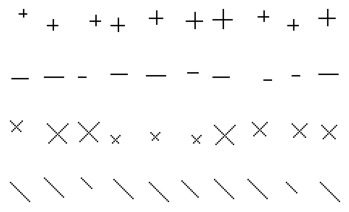

In [10]:
def make_images(n_each_class):
    '''Make 20x20 black and white images with diamonds or squares for the two classes, as line drawings.'''
    images = np.zeros((n_each_class * 4, 20, 20))  # nSamples, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(n_each_class * 4, 1))
    centers = np.zeros((n_each_class * 4, 2))
    for i in range(n_each_class * 4):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < n_each_class:
            # plus
            images[i, x - r:x + r, y] = 1.0
            images[i, x, y - r:y + r] = 1.0
        elif i < n_each_class * 2:
            # minus
            images[i, x, y - r:y + r] = 1.0
        elif i < n_each_class * 3:
            # x
            images[i, range(x - r, x + r), range(y - r, y + r)] = 1.0
            images[i, range(x - r, x + r), range(y + r, y - r, -1)] = 1.0
        else:
            # /
            images[i, range(x - r, x + r), range(y - r, y + r)] = 1.0

    T = np.array(['plus'] * n_each_class + ['minus'] * n_each_class + ['times'] * n_each_class + ['divide'] * n_each_class).reshape(-1, 1)

    n, r, c = images.shape
    images = images.reshape(n, r, c, 1)  # add channel dimsension
    return images, T

n_each_class = 10
X, T = make_images(n_each_class)
p = 0
for i in range(4 * n_each_class):
    p += 1
    plt.subplot(4, n_each_class, p)
    plt.imshow(-X[i, :, :, 0], cmap='gray')
    plt.axis('off')

In [11]:
n_each_class = 500
X, T = make_images(n_each_class)

In [12]:
import pandas as pd

In [13]:
struct = [ [[2, 5, 1]], [5] ]
n_epochs = 10
method= 'adam'
learning_rate = 0.01
batch_size = 10

n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
ntrain = int(n_samples * 0.8)
nval = int(n_samples * 0.1)
Xtrain = X[rows[:ntrain], ...]
Ttrain = T[rows[:ntrain], ...]
Xval = X[rows[ntrain:ntrain+nval], ...]
Tval = T[rows[ntrain:ntrain+nval], ...]
Xtest = X[rows[ntrain+nval:], ...]
Ttest = T[rows[ntrain+nval:], ...]
           
result = train_this_partition(Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,
                              struct, n_epochs, method, learning_rate, batch_size)
result

adam: Epoch 1 n_batches=160 ObjectiveF=0.84785
adam: Epoch 2 n_batches=160 ObjectiveF=0.78727
adam: Epoch 3 n_batches=160 ObjectiveF=0.83303
adam: Epoch 4 n_batches=160 ObjectiveF=0.83491
adam: Epoch 5 n_batches=160 ObjectiveF=0.80451
adam: Epoch 6 n_batches=160 ObjectiveF=0.88797
adam: Epoch 7 n_batches=160 ObjectiveF=0.77177
adam: Epoch 8 n_batches=160 ObjectiveF=0.77721
adam: Epoch 9 n_batches=160 ObjectiveF=0.79119
adam: Epoch 10 n_batches=160 ObjectiveF=0.72274


[(((2, 5, 1),), (5,)), 'adam', 10, 0.01, 10, 60.9375, 62.5, 57.49999999999999]

In [14]:
df = run_these_parameters(X, T, n_folds=4,
                         structs=[[[[5, 3, 1]], []],],
                          methods=['adam'], # , 'sgd'],
                          epochs=[10, 20],
                          learning_rates=[0.01], #, 0.1],
                          batch_sizes=[-1, 10, 50, 100])
df

adam: Epoch 1 n_batches=1 ObjectiveF=0.70563
adam: Epoch 2 n_batches=1 ObjectiveF=0.61700
adam: Epoch 3 n_batches=1 ObjectiveF=0.68154
adam: Epoch 4 n_batches=1 ObjectiveF=0.74738
adam: Epoch 5 n_batches=1 ObjectiveF=0.75117
adam: Epoch 6 n_batches=1 ObjectiveF=0.73954
adam: Epoch 7 n_batches=1 ObjectiveF=0.75063
adam: Epoch 8 n_batches=1 ObjectiveF=0.77597
adam: Epoch 9 n_batches=1 ObjectiveF=0.80140
adam: Epoch 10 n_batches=1 ObjectiveF=0.81929
adam: Epoch 1 n_batches=1 ObjectiveF=0.70586
adam: Epoch 2 n_batches=1 ObjectiveF=0.77007
adam: Epoch 3 n_batches=1 ObjectiveF=0.80335
adam: Epoch 4 n_batches=1 ObjectiveF=0.79498
adam: Epoch 5 n_batches=1 ObjectiveF=0.81274
adam: Epoch 6 n_batches=1 ObjectiveF=0.83643
adam: Epoch 7 n_batches=1 ObjectiveF=0.83883
adam: Epoch 8 n_batches=1 ObjectiveF=0.84159
adam: Epoch 9 n_batches=1 ObjectiveF=0.84748
adam: Epoch 10 n_batches=1 ObjectiveF=0.84993
adam: Epoch 1 n_batches=1 ObjectiveF=0.70426
adam: Epoch 2 n_batches=1 ObjectiveF=0.58949
adam: Ep

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((5, 3, 1),), ())",adam,10,0.01,-1,76.3,71.0,73.8
1,"(((5, 3, 1),), ())",adam,10,0.01,-1,80.0,74.6,78.0
2,"(((5, 3, 1),), ())",adam,10,0.01,-1,70.9,69.4,71.2
3,"(((5, 3, 1),), ())",adam,10,0.01,-1,79.0,77.0,73.8
4,"(((5, 3, 1),), ())",adam,10,0.01,-1,68.1,61.2,62.6
...,...,...,...,...,...,...,...,...
91,"(((5, 3, 1),), ())",adam,20,0.01,100,92.8,77.4,81.0
92,"(((5, 3, 1),), ())",adam,20,0.01,100,91.7,79.2,78.8
93,"(((5, 3, 1),), ())",adam,20,0.01,100,94.9,78.4,80.8
94,"(((5, 3, 1),), ())",adam,20,0.01,100,93.4,77.2,79.8


# Experiments

When you have `train_this_partition` and `run_these_parameters`, use them to explore the parameter values, trying to find combinations of parameter values that result in high validation accuracies.  

Start with one value for each of the five parameters, but remember to specifiy them as a list of one element, like `learning_rates=[0.01]`.  Then run again with 3 or 4 values for one parameter.  Note the best value.  Use that value for that parameter, then add more values for a different parameter.  

Proceed this way for each of the parameter values.  Discuss what you observe after each call to `run_these_parameters` with at least two sentences for each run.  Do the parameter values you find that work best surprise you?  Also discuss how well the validation and test accuracies equal each other.

For each method, try various hidden layer structures, learning rates, and numbers of epochs.  Use the validation percent accuracy to pick the best hidden layers, learning rates and numbers of epochs for each method.  Report training, validation and test accuracy for your best validation results for each of the three methods.


In [15]:
df = run_these_parameters(X, T, n_folds=3,
                         structs=[[[[4, 2, 1]], []],],
                          methods=['sgd'], # , 'sgd'],
                          epochs=[10],
                          learning_rates=[0.01], #, 0.1],
                          batch_sizes=[10])
df

sgd: Epoch 1 n_batches=68 ObjectiveF=0.72398
sgd: Epoch 2 n_batches=68 ObjectiveF=0.74092
sgd: Epoch 3 n_batches=68 ObjectiveF=0.73629
sgd: Epoch 4 n_batches=68 ObjectiveF=0.79980
sgd: Epoch 5 n_batches=68 ObjectiveF=0.75063
sgd: Epoch 6 n_batches=68 ObjectiveF=0.75809
sgd: Epoch 7 n_batches=68 ObjectiveF=0.74546
sgd: Epoch 8 n_batches=68 ObjectiveF=0.85129
sgd: Epoch 9 n_batches=68 ObjectiveF=0.77963
sgd: Epoch 10 n_batches=68 ObjectiveF=0.78871
sgd: Epoch 1 n_batches=67 ObjectiveF=0.73452
sgd: Epoch 2 n_batches=67 ObjectiveF=0.74515
sgd: Epoch 3 n_batches=67 ObjectiveF=0.75984
sgd: Epoch 4 n_batches=67 ObjectiveF=0.73083
sgd: Epoch 5 n_batches=67 ObjectiveF=0.83046
sgd: Epoch 6 n_batches=67 ObjectiveF=0.63377
sgd: Epoch 7 n_batches=67 ObjectiveF=0.82543
sgd: Epoch 8 n_batches=67 ObjectiveF=0.76493
sgd: Epoch 9 n_batches=67 ObjectiveF=0.83325
sgd: Epoch 10 n_batches=67 ObjectiveF=0.81007
sgd: Epoch 1 n_batches=68 ObjectiveF=0.70232
sgd: Epoch 2 n_batches=68 ObjectiveF=0.75276
sgd: Epo

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((4, 2, 1),), ())",sgd,10,0.01,10,74.702381,73.192771,72.740964
1,"(((4, 2, 1),), ())",sgd,10,0.01,10,73.945783,66.815476,70.030120
2,"(((4, 2, 1),), ())",sgd,10,0.01,10,70.386905,69.427711,69.427711
3,"(((4, 2, 1),), ())",sgd,10,0.01,10,74.397590,69.047619,70.632530
4,"(((4, 2, 1),), ())",sgd,10,0.01,10,68.072289,61.897590,59.077381
5,"(((4, 2, 1),), ())",sgd,10,0.01,10,75.451807,71.084337,68.601190


In [16]:
df = run_these_parameters(X, T, n_folds=3,
                         structs=[[[[2, 3, 1]], []],],
                          methods=['sgd'], # , 'sgd'],
                          epochs=[10,50],
                          learning_rates=[0.01,0.1], #, 0.1],
                          batch_sizes=[10,50])
df

sgd: Epoch 1 n_batches=68 ObjectiveF=0.73590
sgd: Epoch 2 n_batches=68 ObjectiveF=0.74810
sgd: Epoch 3 n_batches=68 ObjectiveF=0.76878
sgd: Epoch 4 n_batches=68 ObjectiveF=0.78812
sgd: Epoch 5 n_batches=68 ObjectiveF=0.76569
sgd: Epoch 6 n_batches=68 ObjectiveF=0.82425
sgd: Epoch 7 n_batches=68 ObjectiveF=0.84147
sgd: Epoch 8 n_batches=68 ObjectiveF=0.88387
sgd: Epoch 9 n_batches=68 ObjectiveF=0.73758
sgd: Epoch 10 n_batches=68 ObjectiveF=0.76659
sgd: Epoch 1 n_batches=67 ObjectiveF=0.76307
sgd: Epoch 2 n_batches=67 ObjectiveF=0.85255
sgd: Epoch 3 n_batches=67 ObjectiveF=0.72737
sgd: Epoch 4 n_batches=67 ObjectiveF=0.90481
sgd: Epoch 5 n_batches=67 ObjectiveF=0.79126
sgd: Epoch 6 n_batches=67 ObjectiveF=0.79270
sgd: Epoch 7 n_batches=67 ObjectiveF=0.82151
sgd: Epoch 8 n_batches=67 ObjectiveF=0.80621
sgd: Epoch 9 n_batches=67 ObjectiveF=0.77040
sgd: Epoch 10 n_batches=67 ObjectiveF=0.84844
sgd: Epoch 1 n_batches=68 ObjectiveF=0.73247
sgd: Epoch 2 n_batches=68 ObjectiveF=0.76226
sgd: Epo

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((2, 3, 1),), ())",sgd,10,0.01,10,78.869048,73.493976,76.054217
1,"(((2, 3, 1),), ())",sgd,10,0.01,10,75.903614,74.404762,75.451807
2,"(((2, 3, 1),), ())",sgd,10,0.01,10,77.380952,73.343373,70.933735
3,"(((2, 3, 1),), ())",sgd,10,0.01,10,72.289157,70.684524,69.728916
4,"(((2, 3, 1),), ())",sgd,10,0.01,10,75.451807,74.397590,73.809524
5,"(((2, 3, 1),), ())",sgd,10,0.01,10,73.644578,71.084337,73.065476
6,"(((2, 3, 1),), ())",sgd,10,0.01,50,71.875000,69.427711,67.018072
7,"(((2, 3, 1),), ())",sgd,10,0.01,50,67.921687,63.988095,64.307229
8,"(((2, 3, 1),), ())",sgd,10,0.01,50,68.303571,63.554217,65.963855
9,"(((2, 3, 1),), ())",sgd,10,0.01,50,72.590361,69.791667,69.277108


In [17]:
df = run_these_parameters(X, T, n_folds=4,
                         structs=[[[[10, 5, 1]], []],],
                          methods=['adam'], # , 'sgd'],
                          epochs=[10],
                          learning_rates=[0.1], #, 0.1],
                          batch_sizes=[25])
df

adam: Epoch 1 n_batches=40 ObjectiveF=0.00018
adam: Epoch 2 n_batches=40 ObjectiveF=0.00018
adam: Epoch 3 n_batches=40 ObjectiveF=0.00012
adam: Epoch 4 n_batches=40 ObjectiveF=0.00012
adam: Epoch 5 n_batches=40 ObjectiveF=0.00012
adam: Epoch 6 n_batches=40 ObjectiveF=0.00012
adam: Epoch 7 n_batches=40 ObjectiveF=0.00018
adam: Epoch 8 n_batches=40 ObjectiveF=0.00012
adam: Epoch 9 n_batches=40 ObjectiveF=0.00018
adam: Epoch 10 n_batches=40 ObjectiveF=0.00012
adam: Epoch 1 n_batches=40 ObjectiveF=0.00018
adam: Epoch 2 n_batches=40 ObjectiveF=0.00018
adam: Epoch 3 n_batches=40 ObjectiveF=0.00036
adam: Epoch 4 n_batches=40 ObjectiveF=0.00018
adam: Epoch 5 n_batches=40 ObjectiveF=0.00018
adam: Epoch 6 n_batches=40 ObjectiveF=0.00036
adam: Epoch 7 n_batches=40 ObjectiveF=0.00036
adam: Epoch 8 n_batches=40 ObjectiveF=0.00018
adam: Epoch 9 n_batches=40 ObjectiveF=0.00018
adam: Epoch 10 n_batches=40 ObjectiveF=0.00018
adam: Epoch 1 n_batches=40 ObjectiveF=0.00018
adam: Epoch 2 n_batches=40 Objec

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((10, 5, 1),), ())",adam,10,0.1,25,25.0,25.0,25.0
1,"(((10, 5, 1),), ())",adam,10,0.1,25,25.0,25.0,25.0
2,"(((10, 5, 1),), ())",adam,10,0.1,25,25.0,25.0,25.0
3,"(((10, 5, 1),), ())",adam,10,0.1,25,24.6,24.6,25.0
4,"(((10, 5, 1),), ())",adam,10,0.1,25,24.9,24.8,25.2
5,"(((10, 5, 1),), ())",adam,10,0.1,25,25.0,25.0,25.0
6,"(((10, 5, 1),), ())",adam,10,0.1,25,25.0,25.0,25.0
7,"(((10, 5, 1),), ())",adam,10,0.1,25,25.0,25.0,25.0
8,"(((10, 5, 1),), ())",adam,10,0.1,25,25.0,25.0,25.0
9,"(((10, 5, 1),), ())",adam,10,0.1,25,25.0,25.0,25.0


In [18]:
df = run_these_parameters(X, T, n_folds=3,
                         structs=[[[[3, 5, 1]], []],],
                          methods=['adam'], # , 'sgd'],
                          epochs=[25,50],
                          learning_rates=[0.1], #, 0.1],
                          batch_sizes=[10, 25, 50])
df

adam: Epoch 2 n_batches=68 ObjectiveF=0.00012
adam: Epoch 4 n_batches=68 ObjectiveF=0.00030
adam: Epoch 6 n_batches=68 ObjectiveF=0.00182
adam: Epoch 8 n_batches=68 ObjectiveF=0.00030
adam: Epoch 10 n_batches=68 ObjectiveF=0.00030
adam: Epoch 12 n_batches=68 ObjectiveF=0.00030
adam: Epoch 14 n_batches=68 ObjectiveF=0.00030
adam: Epoch 16 n_batches=68 ObjectiveF=0.00030
adam: Epoch 18 n_batches=68 ObjectiveF=0.00030
adam: Epoch 20 n_batches=68 ObjectiveF=0.00030
adam: Epoch 22 n_batches=68 ObjectiveF=0.00030
adam: Epoch 24 n_batches=68 ObjectiveF=0.00030
adam: Epoch 25 n_batches=68 ObjectiveF=0.00030
adam: Epoch 2 n_batches=67 ObjectiveF=0.00025
adam: Epoch 4 n_batches=67 ObjectiveF=0.00448
adam: Epoch 6 n_batches=67 ObjectiveF=0.00030
adam: Epoch 8 n_batches=67 ObjectiveF=0.00030
adam: Epoch 10 n_batches=67 ObjectiveF=0.00074
adam: Epoch 12 n_batches=67 ObjectiveF=0.00030
adam: Epoch 14 n_batches=67 ObjectiveF=0.00030
adam: Epoch 16 n_batches=67 ObjectiveF=0.00074
adam: Epoch 18 n_batc

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((3, 5, 1),), ())",adam,25,0.1,10,24.553571,24.698795,24.397590
1,"(((3, 5, 1),), ())",adam,25,0.1,10,25.150602,25.148810,25.150602
2,"(((3, 5, 1),), ())",adam,25,0.1,10,25.148810,24.849398,25.000000
3,"(((3, 5, 1),), ())",adam,25,0.1,10,24.698795,24.851190,25.000000
4,"(((3, 5, 1),), ())",adam,25,0.1,10,29.367470,25.301205,26.488095
5,"(((3, 5, 1),), ())",adam,25,0.1,10,25.000000,25.000000,25.000000
6,"(((3, 5, 1),), ())",adam,25,0.1,25,25.000000,25.150602,25.000000
7,"(((3, 5, 1),), ())",adam,25,0.1,25,25.451807,25.000000,25.000000
8,"(((3, 5, 1),), ())",adam,25,0.1,25,25.000000,25.000000,25.150602
9,"(((3, 5, 1),), ())",adam,25,0.1,25,24.246988,24.553571,25.301205


In [19]:
df = run_these_parameters(X, T, n_folds=4,
                         structs=[[[[8, 4, 1]], []],],
                          methods=['sgd'], # , 'sgd'],
                          epochs=[50,100],
                          learning_rates=[0.01], #, 0.1],
                          batch_sizes=[25])
df

sgd: Epoch 5 n_batches=40 ObjectiveF=0.87205
sgd: Epoch 10 n_batches=40 ObjectiveF=0.84880
sgd: Epoch 15 n_batches=40 ObjectiveF=0.81456
sgd: Epoch 20 n_batches=40 ObjectiveF=0.82116
sgd: Epoch 25 n_batches=40 ObjectiveF=0.87093
sgd: Epoch 30 n_batches=40 ObjectiveF=0.86172
sgd: Epoch 35 n_batches=40 ObjectiveF=0.90384
sgd: Epoch 40 n_batches=40 ObjectiveF=0.88115
sgd: Epoch 45 n_batches=40 ObjectiveF=0.84199
sgd: Epoch 50 n_batches=40 ObjectiveF=0.91822
sgd: Epoch 5 n_batches=40 ObjectiveF=0.85502
sgd: Epoch 10 n_batches=40 ObjectiveF=0.80877
sgd: Epoch 15 n_batches=40 ObjectiveF=0.88705
sgd: Epoch 20 n_batches=40 ObjectiveF=0.81926
sgd: Epoch 25 n_batches=40 ObjectiveF=0.87506
sgd: Epoch 30 n_batches=40 ObjectiveF=0.87647
sgd: Epoch 35 n_batches=40 ObjectiveF=0.86903
sgd: Epoch 40 n_batches=40 ObjectiveF=0.84579
sgd: Epoch 45 n_batches=40 ObjectiveF=0.85620
sgd: Epoch 50 n_batches=40 ObjectiveF=0.91489
sgd: Epoch 5 n_batches=40 ObjectiveF=0.86334
sgd: Epoch 10 n_batches=40 ObjectiveF

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((8, 4, 1),), ())",sgd,50,0.01,25,82.6,77.4,79.0
1,"(((8, 4, 1),), ())",sgd,50,0.01,25,84.4,77.4,83.4
2,"(((8, 4, 1),), ())",sgd,50,0.01,25,81.9,81.4,82.8
3,"(((8, 4, 1),), ())",sgd,50,0.01,25,82.3,79.8,78.2
4,"(((8, 4, 1),), ())",sgd,50,0.01,25,84.7,78.2,79.6
5,"(((8, 4, 1),), ())",sgd,50,0.01,25,85.0,79.8,79.4
6,"(((8, 4, 1),), ())",sgd,50,0.01,25,83.7,82.6,78.6
7,"(((8, 4, 1),), ())",sgd,50,0.01,25,84.8,78.8,77.4
8,"(((8, 4, 1),), ())",sgd,50,0.01,25,85.1,80.8,78.2
9,"(((8, 4, 1),), ())",sgd,50,0.01,25,82.3,83.0,80.2


In [20]:
df = run_these_parameters(X, T, n_folds=3,
                         structs=[[[[6, 3, 1]], []],],
                          methods=['sgd'], # , 'sgd'],
                          epochs=[100],
                          learning_rates=[0.01], #, 0.1],
                          batch_sizes=[5,10,20])
df

sgd: Epoch 10 n_batches=135 ObjectiveF=0.87003
sgd: Epoch 20 n_batches=135 ObjectiveF=0.91924
sgd: Epoch 30 n_batches=135 ObjectiveF=0.87373
sgd: Epoch 40 n_batches=135 ObjectiveF=0.87056
sgd: Epoch 50 n_batches=135 ObjectiveF=0.96184
sgd: Epoch 60 n_batches=135 ObjectiveF=0.92779
sgd: Epoch 70 n_batches=135 ObjectiveF=0.94320
sgd: Epoch 80 n_batches=135 ObjectiveF=0.94628
sgd: Epoch 90 n_batches=135 ObjectiveF=0.99478
sgd: Epoch 100 n_batches=135 ObjectiveF=0.96244
sgd: Epoch 10 n_batches=133 ObjectiveF=0.76922
sgd: Epoch 20 n_batches=133 ObjectiveF=0.89912
sgd: Epoch 30 n_batches=133 ObjectiveF=0.93854
sgd: Epoch 40 n_batches=133 ObjectiveF=0.85350
sgd: Epoch 50 n_batches=133 ObjectiveF=0.75640
sgd: Epoch 60 n_batches=133 ObjectiveF=0.93255
sgd: Epoch 70 n_batches=133 ObjectiveF=0.92936
sgd: Epoch 80 n_batches=133 ObjectiveF=0.88994
sgd: Epoch 90 n_batches=133 ObjectiveF=0.98526
sgd: Epoch 100 n_batches=133 ObjectiveF=0.97979
sgd: Epoch 10 n_batches=135 ObjectiveF=0.86620
sgd: Epoch 

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((6, 3, 1),), ())",sgd,100,0.01,5,94.345238,78.313253,80.421687
1,"(((6, 3, 1),), ())",sgd,100,0.01,5,91.566265,76.488095,73.945783
2,"(((6, 3, 1),), ())",sgd,100,0.01,5,94.940476,81.777108,79.367470
3,"(((6, 3, 1),), ())",sgd,100,0.01,5,94.427711,79.315476,79.216867
4,"(((6, 3, 1),), ())",sgd,100,0.01,5,94.126506,76.656627,80.059524
5,"(((6, 3, 1),), ())",sgd,100,0.01,5,93.975904,77.560241,78.869048
6,"(((6, 3, 1),), ())",sgd,100,0.01,10,92.261905,79.969880,81.024096
7,"(((6, 3, 1),), ())",sgd,100,0.01,10,88.403614,81.398810,80.120482
8,"(((6, 3, 1),), ())",sgd,100,0.01,10,92.410714,81.024096,79.518072
9,"(((6, 3, 1),), ())",sgd,100,0.01,10,89.307229,78.273810,77.560241


In [21]:
df = run_these_parameters(X, T, n_folds=4,
                         structs=[[[[8, 4, 1]], []],],
                          methods=['sgd'], # , 'sgd'],
                          epochs=[50,100],
                          learning_rates=[0.01], #, 0.1],
                          batch_sizes=[5,20])
df

sgd: Epoch 5 n_batches=200 ObjectiveF=0.86819
sgd: Epoch 10 n_batches=200 ObjectiveF=0.95565
sgd: Epoch 15 n_batches=200 ObjectiveF=0.61107
sgd: Epoch 20 n_batches=200 ObjectiveF=0.66987
sgd: Epoch 25 n_batches=200 ObjectiveF=0.88597
sgd: Epoch 30 n_batches=200 ObjectiveF=0.90130
sgd: Epoch 35 n_batches=200 ObjectiveF=0.92080
sgd: Epoch 40 n_batches=200 ObjectiveF=0.96920
sgd: Epoch 45 n_batches=200 ObjectiveF=0.94464
sgd: Epoch 50 n_batches=200 ObjectiveF=0.93573
sgd: Epoch 5 n_batches=200 ObjectiveF=0.89141
sgd: Epoch 10 n_batches=200 ObjectiveF=0.87234
sgd: Epoch 15 n_batches=200 ObjectiveF=0.81922
sgd: Epoch 20 n_batches=200 ObjectiveF=0.88038
sgd: Epoch 25 n_batches=200 ObjectiveF=0.90549
sgd: Epoch 30 n_batches=200 ObjectiveF=0.98018
sgd: Epoch 35 n_batches=200 ObjectiveF=0.98237
sgd: Epoch 40 n_batches=200 ObjectiveF=0.87704
sgd: Epoch 45 n_batches=200 ObjectiveF=0.89137
sgd: Epoch 50 n_batches=200 ObjectiveF=0.87409
sgd: Epoch 5 n_batches=200 ObjectiveF=0.98018
sgd: Epoch 10 n_

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((8, 4, 1),), ())",sgd,50,0.01,5,93.8,79.6,78.2
1,"(((8, 4, 1),), ())",sgd,50,0.01,5,91.6,83.6,78.0
2,"(((8, 4, 1),), ())",sgd,50,0.01,5,94.8,84.4,78.8
3,"(((8, 4, 1),), ())",sgd,50,0.01,5,94.3,80.0,79.2
4,"(((8, 4, 1),), ())",sgd,50,0.01,5,93.2,82.8,82.0
5,"(((8, 4, 1),), ())",sgd,50,0.01,5,89.8,81.0,80.6
6,"(((8, 4, 1),), ())",sgd,50,0.01,5,93.3,80.8,85.0
7,"(((8, 4, 1),), ())",sgd,50,0.01,5,89.3,77.4,76.0
8,"(((8, 4, 1),), ())",sgd,50,0.01,5,92.8,85.6,83.2
9,"(((8, 4, 1),), ())",sgd,50,0.01,5,90.1,76.8,81.0


In [22]:
df = run_these_parameters(X, T, n_folds=3,
                         structs=[[[[6, 3, 1]], []],],
                          methods=['adam'], # , 'sgd'],
                          epochs=[100],
                          learning_rates=[0.01], #, 0.1],
                          batch_sizes=[5,10,20])
df

adam: Epoch 10 n_batches=135 ObjectiveF=0.77521
adam: Epoch 20 n_batches=135 ObjectiveF=0.94551
adam: Epoch 30 n_batches=135 ObjectiveF=0.02555
adam: Epoch 40 n_batches=135 ObjectiveF=0.00449
adam: Epoch 50 n_batches=135 ObjectiveF=0.00012
adam: Epoch 60 n_batches=135 ObjectiveF=0.00061
adam: Epoch 70 n_batches=135 ObjectiveF=0.00022
adam: Epoch 80 n_batches=135 ObjectiveF=0.00012
adam: Epoch 90 n_batches=135 ObjectiveF=0.00074
adam: Epoch 100 n_batches=135 ObjectiveF=0.00466
adam: Epoch 10 n_batches=133 ObjectiveF=0.97677
adam: Epoch 20 n_batches=133 ObjectiveF=0.00074
adam: Epoch 30 n_batches=133 ObjectiveF=0.11837
adam: Epoch 40 n_batches=133 ObjectiveF=0.00012
adam: Epoch 50 n_batches=133 ObjectiveF=0.00016
adam: Epoch 60 n_batches=133 ObjectiveF=0.02720
adam: Epoch 70 n_batches=133 ObjectiveF=0.00074
adam: Epoch 80 n_batches=133 ObjectiveF=0.00074
adam: Epoch 90 n_batches=133 ObjectiveF=0.00074
adam: Epoch 100 n_batches=133 ObjectiveF=0.00012
adam: Epoch 10 n_batches=135 Objective

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((6, 3, 1),), ())",adam,100,0.01,5,31.101190,33.283133,33.283133
1,"(((6, 3, 1),), ())",adam,100,0.01,5,27.409639,23.065476,21.084337
2,"(((6, 3, 1),), ())",adam,100,0.01,5,50.595238,44.728916,47.891566
3,"(((6, 3, 1),), ())",adam,100,0.01,5,34.186747,30.505952,28.463855
4,"(((6, 3, 1),), ())",adam,100,0.01,5,43.825301,43.222892,41.220238
5,"(((6, 3, 1),), ())",adam,100,0.01,5,43.373494,39.608434,36.309524
6,"(((6, 3, 1),), ())",adam,100,0.01,10,42.410714,38.102410,44.578313
7,"(((6, 3, 1),), ())",adam,100,0.01,10,41.114458,41.369048,37.500000
8,"(((6, 3, 1),), ())",adam,100,0.01,10,28.869048,26.506024,27.108434
9,"(((6, 3, 1),), ())",adam,100,0.01,10,26.506024,27.083333,26.656627


In [23]:
df = run_these_parameters(X, T, n_folds=4,
                         structs=[[[[6, 4, 2]], []],],
                          methods=['sgd'], # , 'sgd'],
                          epochs=[10,25],
                          learning_rates=[0.01], #, 0.1],
                          batch_sizes=[10,25])
df

sgd: Epoch 1 n_batches=100 ObjectiveF=0.77327
sgd: Epoch 2 n_batches=100 ObjectiveF=0.85179
sgd: Epoch 3 n_batches=100 ObjectiveF=0.83917
sgd: Epoch 4 n_batches=100 ObjectiveF=0.81781
sgd: Epoch 5 n_batches=100 ObjectiveF=0.88461
sgd: Epoch 6 n_batches=100 ObjectiveF=0.88497
sgd: Epoch 7 n_batches=100 ObjectiveF=0.80618
sgd: Epoch 8 n_batches=100 ObjectiveF=0.80281
sgd: Epoch 9 n_batches=100 ObjectiveF=0.81751
sgd: Epoch 10 n_batches=100 ObjectiveF=0.92855
sgd: Epoch 1 n_batches=100 ObjectiveF=0.73050
sgd: Epoch 2 n_batches=100 ObjectiveF=0.76957
sgd: Epoch 3 n_batches=100 ObjectiveF=0.83197
sgd: Epoch 4 n_batches=100 ObjectiveF=0.85342
sgd: Epoch 5 n_batches=100 ObjectiveF=0.78782
sgd: Epoch 6 n_batches=100 ObjectiveF=0.91061
sgd: Epoch 7 n_batches=100 ObjectiveF=0.87029
sgd: Epoch 8 n_batches=100 ObjectiveF=0.84972
sgd: Epoch 9 n_batches=100 ObjectiveF=0.79973
sgd: Epoch 10 n_batches=100 ObjectiveF=0.81175
sgd: Epoch 1 n_batches=100 ObjectiveF=0.72903
sgd: Epoch 2 n_batches=100 Objec

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((6, 4, 2),), ())",sgd,10,0.01,10,74.7,69.8,76.6
1,"(((6, 4, 2),), ())",sgd,10,0.01,10,73.8,75.4,77.2
2,"(((6, 4, 2),), ())",sgd,10,0.01,10,73.9,72.0,74.0
3,"(((6, 4, 2),), ())",sgd,10,0.01,10,72.7,74.4,68.6
4,"(((6, 4, 2),), ())",sgd,10,0.01,10,78.2,76.6,72.0
5,"(((6, 4, 2),), ())",sgd,10,0.01,10,79.8,75.4,74.6
6,"(((6, 4, 2),), ())",sgd,10,0.01,10,75.8,76.4,75.8
7,"(((6, 4, 2),), ())",sgd,10,0.01,10,77.1,70.2,75.2
8,"(((6, 4, 2),), ())",sgd,10,0.01,10,77.9,77.0,78.2
9,"(((6, 4, 2),), ())",sgd,10,0.01,10,75.6,75.8,74.0


In [24]:
df = run_these_parameters(X, T, n_folds=4,
                         structs=[[[[8, 5, 2]], []],],
                          methods=['adam'], # , 'sgd'],
                          epochs=[50],
                          learning_rates=[0.01,0.1], #, 0.1],
                          batch_sizes=[25])
df

adam: Epoch 5 n_batches=40 ObjectiveF=0.91309
adam: Epoch 10 n_batches=40 ObjectiveF=0.89210
adam: Epoch 15 n_batches=40 ObjectiveF=0.92575
adam: Epoch 20 n_batches=40 ObjectiveF=0.93980
adam: Epoch 25 n_batches=40 ObjectiveF=0.96199
adam: Epoch 30 n_batches=40 ObjectiveF=0.98980
adam: Epoch 35 n_batches=40 ObjectiveF=0.98807
adam: Epoch 40 n_batches=40 ObjectiveF=0.98744
adam: Epoch 45 n_batches=40 ObjectiveF=0.96915
adam: Epoch 50 n_batches=40 ObjectiveF=0.93388
adam: Epoch 5 n_batches=40 ObjectiveF=0.87716
adam: Epoch 10 n_batches=40 ObjectiveF=0.92529
adam: Epoch 15 n_batches=40 ObjectiveF=0.96732
adam: Epoch 20 n_batches=40 ObjectiveF=0.92163
adam: Epoch 25 n_batches=40 ObjectiveF=0.93785
adam: Epoch 30 n_batches=40 ObjectiveF=0.97829
adam: Epoch 35 n_batches=40 ObjectiveF=0.98142
adam: Epoch 40 n_batches=40 ObjectiveF=0.98374
adam: Epoch 45 n_batches=40 ObjectiveF=0.99455
adam: Epoch 50 n_batches=40 ObjectiveF=0.99697
adam: Epoch 5 n_batches=40 ObjectiveF=0.91720
adam: Epoch 10 n

,struct,method,n_epochs,learning_rate,batch_size,train %,val %,test %
0,"(((8, 5, 2),), ())",adam,50,0.01,25,98.3,78.2,80.0
1,"(((8, 5, 2),), ())",adam,50,0.01,25,99.2,84.2,83.8
2,"(((8, 5, 2),), ())",adam,50,0.01,25,99.8,87.8,86.8
3,"(((8, 5, 2),), ())",adam,50,0.01,25,98.8,83.2,81.8
4,"(((8, 5, 2),), ())",adam,50,0.01,25,100.0,86.6,84.2
5,"(((8, 5, 2),), ())",adam,50,0.01,25,95.2,84.2,81.0
6,"(((8, 5, 2),), ())",adam,50,0.01,25,99.8,83.8,84.8
7,"(((8, 5, 2),), ())",adam,50,0.01,25,100.0,85.4,87.0
8,"(((8, 5, 2),), ())",adam,50,0.01,25,99.7,86.4,85.2
9,"(((8, 5, 2),), ())",adam,50,0.01,25,99.7,86.4,88.0


In [25]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

## Observations:

1) The run_these_parameters function loops through different values of learning rates, methods, batch_size and epochs to calculate train, validation and test accuracies by calling the train_this_partition function for given value of n_folds.

2) If n_folds = 4, then there will be 12 combinations of partitions will be generated for the train, validation and test datasets combined.

3) The SGD optimizer performs much better than the ADAM optimizer where the learning rate is 0.01 for multiple n_epochs values and fewer batch_sizes values passed in the run_these_parameter function.

4) The best validation accuracy is obtained when the layer structure = ([8, 4, 1]), ([]) for SGD optimizer where there is only convolutional layers and no fully connected layers in which network model is trained for epochs = [20, 50]; learning rate = 0.01; and batch sizes = [5,20].

5) For this network structure, the mean of the validation accuracy is in the range of 78%-80%, the mean of the test accuracy is in the range of 79%-81%, and the train accuracy is in the range of 86%-93%.

6) It is been observed that the mean of the validation and test accuracies are nearly equal to each other for the above-mentioned network structure, as a result the mean of the training accuracy for this network model tends to be the highest when compared to the other convolutional neural network models.

7) Generating higher partitions of validation dataset might potentially be a reason for getting almost equal values for the mean validation and testing accuracies in the cnn model which in turn yields good training accuracy.

8) The two important parameters that need to be given accordingly to get good train acuracy and equally good mean validation and test accuracies are n_folds which is responsible for creating partitions and batch_size which is responsible to train neural network model in batches.

# Grading

(UPDATED Oct. 21, 9:35am, tolerance on accuracies is now larger) Download [A4grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.tar), extract `A4grader.py` before running the following cell.

In [15]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Raveendiran-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing:

    def make_images(n_each_class):
        images = np.zeros((n_each_class * 2, 20, 20))  # nSamples, rows, columns
        radii = 3 + np.random.randint(10 - 5, size=(n_each_class * 2, 1))
        centers = np.zeros((n_each_class * 2, 2))
        for i in range(n_each_class * 2):
            r = radii[i, 0]
            centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
            x = int(centers[i, 0])
            y = int(centers[i, 1])
            if i < n_each_class:
                # squares
                images[i, x - r:x + r, y + r] = 1.0
                images[i, x - r:x + r, y - r] = 1.0
                images[i, x - r, y - r:y + r] = 1.0
                images[i, x + r, y - r:y + r + 1] = 1.0
            els

<Figure size 432x288 with 0 Axes>

# Extra Credit

Repeat the above experiment using a convolutional neural network defined in `Pytorch`.  Implement this yourself by directly calling `torch.nn` functions.